## import module

In [1]:
import numpy as np
from math import copysign
import matplotlib.pyplot as plt
from tqdm import tqdm
from missile_gym import MissileGym
import pickle
from matplotlib.pylab import subplot2grid
import ipywidgets as iw
from ipywidgets import interact

In [2]:
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

## function

In [3]:
with open('saves/opts.bin', 'rb') as f:
    opts = pickle.load(f)

In [4]:
opts['tau'] = 0.05

In [9]:
opts['am'] = 15

In [5]:
opts

{'m_0': 1873.7742183674898,
 'vel_abs': 1503.7473813024806,
 't_marsh': 11.275862068965518,
 'w_marsh': 1123.7742183674898,
 'P_marsh': 254137.93103448275,
 'dt': 0.05,
 'tau': 0.05,
 't_max': 165,
 'I': 2550,
 'r_kill': 50,
 'alpha_max': 20,
 'am': 5,
 'dny': 1,
 'init_conditions': {'V_0': 25, 'pos_0': (0, 20)},
 'd': 0.515,
 'L_korp': 8.298,
 'L_cil': 5.519,
 'L_korm': 0.135,
 'L_oper': 1.25,
 'L_kon1': 0.913,
 'L_kon2': 1.731,
 'b_0_oper': 1.36,
 'x_b_oper': 7.37,
 'a': 0.2,
 'betta_kon2': 1,
 'd_korm': 0.49,
 'c_oper': 0.03,
 'khi_pk_oper': 55,
 'khi_rul': 0.0,
 'class_korp': 7,
 'class_oper': 5,
 'S_oper': 1.1,
 'x_ct_0': 4.808396444826858,
 'x_ct_marsh': 4.137372904870341}

In [10]:
def single_hit(mis_opts, trg_pos, trg_vel, record=True):
    """
    Функция тренажера огня, моделирующая движение ц.м. ракеты к цели с заданным простым постоянным вектором скорости
    arguments: mis_opts {dict} -- параметры ракеты
               trg_pos {tuple/list/np.ndarray} -- положение цели
               trg_vel {tuple/np.ndarray} -- скорость цели
    keyword arguments: record {bool} -- включатель записи результатов (состояний) моделирования шагов по времени,
                                        иначе возвращается последнее состояние моделирования {default: False}
    returns: {dict} if record = True
             (tuple) if record = False
    """
    gym = MissileGym.make_simple_scenario(mis_opts, trg_pos, trg_vel)
    done = False
    obs = gym.reset()
    state = gym.get_state()
    history = [(state, obs, done, {})]
    alphas_targeting = [0]
    
    while not done:
        obs, done, info = gym.step_with_guidance()
        state = gym.get_state()
        if record:
            history.append((state, obs, done, info))
            alphas_targeting.append(gym.missile.alpha_targeting if abs(gym.missile.alpha_targeting) < gym.missile.alpha_max else copysign(gym.missile.alpha_max, gym.missile.alpha_targeting))
    
    inf = info['done_reason']
    print(f'info = {inf}')
    
    if record:
        mis_vs, mis_xs, mis_ys, mis_vels, alphas, Qs = [], [], [], [], [], []
        trg_xs, trg_ys, trg_vs, trg_vels = [], [], [], []
        infos, ts = [], []
        
        for state, obs, done, info in history:
            gym.set_state(state)
            mis_smry = gym.missile.get_summary()
            trg_smry = gym.target.get_summary()
            mis_xs.append(mis_smry['x'])
            mis_ys.append(mis_smry['y'])
            trg_xs.append(trg_smry['x'])
            trg_ys.append(trg_smry['y'])
            ts.append(mis_smry['t'])
            mis_vs.append(mis_smry['v'])
            trg_vs.append(trg_smry['v'])
            alphas.append(mis_smry['alpha'])
            Qs.append(mis_smry['Q'])
            trg_vels.append(gym.target.vel)
            mis_vels.append(gym.missile.vel)
            infos.append(info)

        trg_nys = [MissileGym.get_overload(v0, v1, t1-t0)[1] for v0, v1, t1, t0 in zip(trg_vels, trg_vels[1:], ts[1:], ts)]
        trg_nys += [trg_nys[-1]]
        mis_nys = [MissileGym.get_overload(v0, v1, t1-t0)[1] for v0, v1, t1, t0 in zip(mis_vels, mis_vels[1:], ts[1:], ts)]
        mis_nys += [trg_nys[-1]]

        trg_nxs = [MissileGym.get_overload(v0, v1, t1-t0)[0] for v0, v1, t1, t0 in zip(trg_vels, trg_vels[1:], ts[1:], ts)]
        trg_nxs += [trg_nxs[-1]]
        mis_nxs = [MissileGym.get_overload(v0, v1, t1-t0)[0] for v0, v1, t1, t0 in zip(mis_vels, mis_vels[1:], ts[1:], ts)]
        mis_nxs += [trg_nxs[-1]]
    
        return {
            't': ts,
            'missile': {'v': mis_vs, 'x': mis_xs, 'y': mis_ys, 'Q': Qs, 'alpha': alphas, 'nx': mis_nxs, 'ny': mis_nys, 'vel': mis_vels},
            'target': {'v': trg_vs, 'x': trg_xs, 'y': trg_ys, 'ny': trg_nys, 'nx': trg_nxs, 'vel': trg_vels},
            'alpha_targeting': alphas_targeting,
            'info': infos 
        }
    else:
        return state, obs, done, info

## ballistic hit

In [11]:
trg_pos = (300e3, 30e3)
trg_vel = (-700, 0)

In [12]:
%time res_hit = single_hit(opts, trg_pos, trg_vel)

info = target destroyed
Wall time: 55.8 s


In [12]:
with open('saves/data_hit.bin', 'wb') as f:
    pickle.dump(res_hit, f)

## vizualizing

In [13]:
with open('saves/data_hit.bin', 'rb') as f:
    res_hit = pickle.load(f)

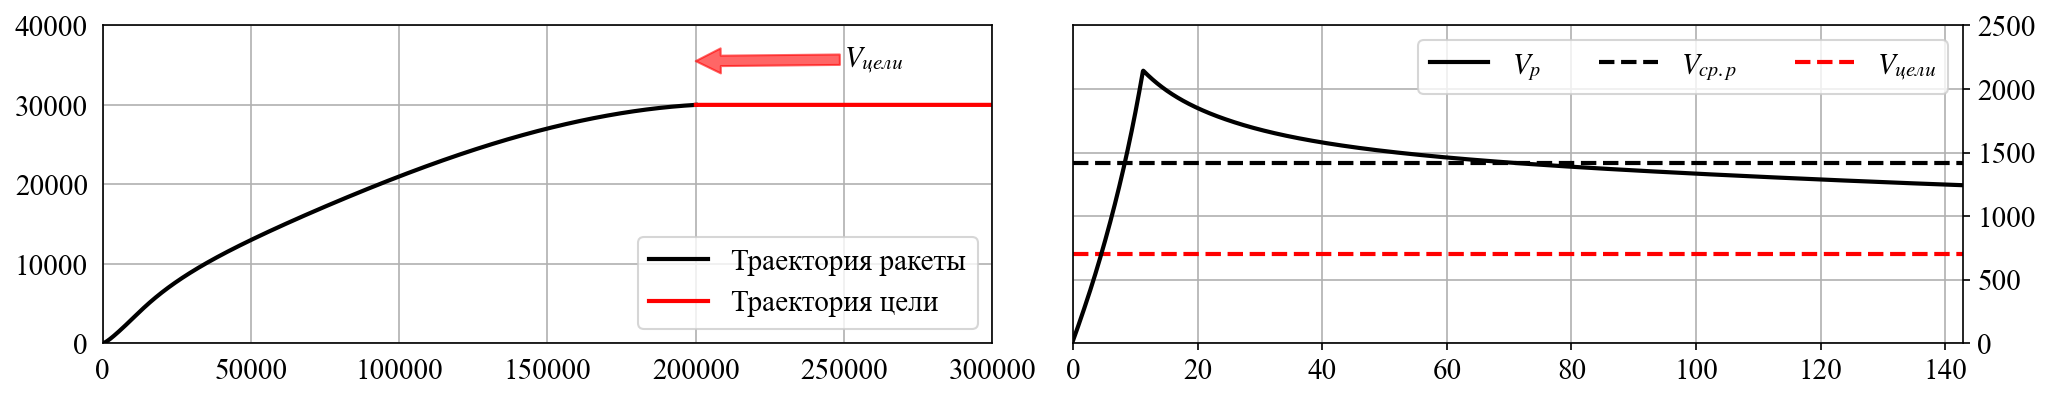

In [13]:
plt.figure(figsize=(16,12), dpi=150)

ax01 = subplot2grid((8, 4), (0, 0), colspan=2, rowspan=2)
ax00 = subplot2grid((8, 4), (0, 2), colspan=2, rowspan=2)

ax00.plot(res_hit['t'], res_hit['missile']['v'], color='k',lw=2, ls='-', label='$V_{р}$')
ax00.hlines(np.average(res_hit['missile']['v']), 0, res_hit['t'][-1], ls='--', color='k', lw=2, label='$V_{ср.р}$')
ax00.hlines(np.linalg.norm(trg_vel), 0, res_hit['t'][-1], ls='--', color='r', lw=2, label='$V_{цели}$')
ax00.legend(loc='best', ncol=3, fontsize=14)
ax00.tick_params(left=False, labelleft=False, right=True, labelright=True, labelsize=14)
ax00.grid(True)
ax00.set_xlim(0, res_hit['t'][-1])
ax00.set_ylim(0, 2.5e3)

ax01.plot(res_hit['missile']['x'], res_hit['missile']['y'], lw=2, ls='-', color='k', label='Траектория ракеты')
ax01.plot(res_hit['target']['x'], res_hit['target']['y'], lw=2, ls='-', color='r', label='Траектория цели')
ax01.legend(loc='lower right', fontsize=14)
ax01.tick_params(left=False, labelleft=True, labelright=False, bottom=False, labelsize=14)
ax01.grid(True)
ax01.set_xlim(0, 300e3)
ax01.set_ylim(0, 40e3)
ax01.annotate('$V_{цели}$', xy=(200e3, 35.5e3), xytext=(250e3, 35e3), 
              arrowprops=dict(width=5, color='r', alpha=0.6), fontsize=14)

plt.savefig('pictures/Баллистическое решение.png', dpi=300, bbox_inches='tight')

In [14]:
fs = 14
@interact(i=iw.IntSlider(description='tau', max=len(res_hit['t'])-1, step=1, value=len(res_hit['t'])-1))
def draw_gym_hit(i):
    
    plt.figure(figsize=(16,12))
    #---------------------------------------------------------------------
    ax01 = subplot2grid((7, 4), (0, 0), colspan=4, rowspan=3)
    ax02 = subplot2grid((7, 4), (3, 0), colspan=2, rowspan=2)
    ax03 = subplot2grid((7, 4), (5, 0), colspan=2, rowspan=2,sharex=ax02)
    ax04 = subplot2grid((7, 4), (3, 2), colspan=2, rowspan=2,sharex=ax02)
    ax05 = subplot2grid((7, 4), (5, 2), colspan=2, rowspan=2,sharex=ax02)
    #---------------------------------------------------------------------
    ax01.plot(res_hit['missile']['x'][:i], res_hit['missile']['y'][:i], lw=3, ls='-', color='k', label='траектория ракеты')
    ax01.plot(res_hit['target']['x'][:i], res_hit['target']['y'][:i], lw=3, ls='-', color='red', label='траектория цели')
    ax01.tick_params(labelsize=fs, pad = 0)
    ax01.legend(loc='center right', fontsize=fs, ncol=2, edgecolor='k')
    ax01.grid(True)
    ax01.set_xlim(0, 300e3)
    ax01.set_ylim(0, 40e3)
    ax01.annotate('$V_{цели}$', xy=(220e3, 35.8e3), xytext=(270e3, 35.6e3), 
              arrowprops=dict(width=3, color='r', alpha=0.6), fontsize=fs)
    ax01.set_ylabel('$м$', fontsize=fs)
    #---------------------------------------------------------------------
    ax02.plot(res_hit['t'][:i], res_hit['missile']['v'][:i], label='$V_р$', c='k', lw=2)
    ax02.hlines(np.average(res_hit['missile']['v']), 0, res_hit['t'][-1], ls='--', color='k', lw=2, label='$V_{ср.р}$')
    ax02.plot(res_hit['t'][:i], res_hit['target']['v'][:i], label='$V_ц$', c='red', ls='--', lw=2)
    ax02.tick_params(left=True, labelleft=True,labelbottom=False, bottom=False, right=False, labelright=False, labelsize=fs)
    ax02.legend(fontsize=fs, ncol=2, edgecolor='k')
    ax02.grid(True)
    ax02.set_xlim(0, res_hit['t'][-1])
    ax02.set_ylim(0, 2.5e3)
    ax02.set_ylabel('$м/с$', fontsize=fs)
    #---------------------------------------------------------------------
    ax03.plot(res_hit['t'][:i], res_hit['missile']['ny'][:i], label=r'$n_y$ ракеты', c='k', lw=2)
    ax03.plot(res_hit['t'][:i], res_hit['target']['ny'][:i], label=r'$n_y$ цели', c='red', lw=2)
    ax03.legend(loc='best', ncol=2, fontsize=fs, edgecolor='k')
    ax03.tick_params(left=True, labelleft=True, right=False, labelright=False, labelsize=fs)
    ax03.grid(True)
    #---------------------------------------------------------------------
    ax04.plot(res_hit['t'][:i], res_hit['missile']['alpha'][:i], label=r'$\alpha$', color='k', lw=2)
    ax04.plot(res_hit['t'][:i], res_hit['alpha_targeting'][:i], label=r'$\alpha_{пот}$', color='darkorange', ls='-', lw=2)
    ax04.plot(res_hit['t'][:i], res_hit['missile']['Q'][:i], color='k', ls='--', label='Q', lw=2)
    ax04.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False, right=True, labelright=True, labelsize=fs)
    ax04.legend(fontsize=fs, edgecolor='k', ncol=2)
    ax04.grid(True)
    ax04.set_ylabel('$град$', fontsize=fs)
    #---------------------------------------------------------------------  
    ax05.plot(res_hit['t'][:i], np.array(res_hit['missile']['nx'][:i]), label=r'$n_x$ ракеты', c='k', ls='-', lw=2)
    ax05.plot(res_hit['t'][:i], res_hit['target']['nx'][:i], label=r'$n_x$ цели', c='red', ls='-', lw=2)
    ax05.tick_params(left=False, labelleft=False, right=True, labelright=True, labelsize=fs)
    ax05.legend(fontsize=fs, edgecolor='k', ncol=2)
    ax05.grid(True)
    
    plt.savefig('pictures/Баллистика.png', dpi=300, bbox_inches='tight')
    
    plt.show()

interactive(children=(IntSlider(value=2856, description='tau', max=2856), Output()), _dom_classes=('widget-int…

In [17]:
np.average(res_hit['missile']['v']), np.max(res_hit['missile']['v'])

(1420.71736027524, 2143.489885998473)

## zone gefeat

In [44]:
def single_hit(mis_opts, trg_pos, trg_vel, record=True):
    gym = MissileGym.make_simple_scenario(mis_opts, trg_pos, trg_vel)
    done = False
    obs = gym.reset()
    state = gym.get_state()
    history = [(state, obs, done, {})]
    alphas_targeting = [0]
    
    while not done:
        obs, done, info = gym.step_with_guidance()
        state = gym.get_state()
        if record:
            history.append((state, obs, done, info))
            alphas_targeting.append(gym.missile.alpha_targeting if abs(gym.missile.alpha_targeting) < gym.missile.alpha_max else copysign(gym.missile.alpha_max, gym.missile.alpha_targeting))
    
    inf = info['done_reason']
    print(f'info = {inf}')
    
    if record:
        mis_vs, mis_xs, mis_ys, mis_vels, alphas, Qs = [], [], [], [], [], []
        trg_xs, trg_ys, trg_vs, trg_vels = [], [], [], []
        infos, ts = [], []
        
        for state, obs, done, info in history:
            gym.set_state(state)
            mis_smry = gym.missile.get_summary()
            trg_smry = gym.target.get_summary()
            mis_xs.append(mis_smry['x'])
            mis_ys.append(mis_smry['y'])
            trg_xs.append(trg_smry['x'])
            trg_ys.append(trg_smry['y'])
            ts.append(mis_smry['t'])
            mis_vs.append(mis_smry['v'])
            trg_vs.append(trg_smry['v'])
            alphas.append(mis_smry['alpha'])
            Qs.append(mis_smry['Q'])
            trg_vels.append(gym.target.vel)
            mis_vels.append(gym.missile.vel)
            infos.append(info)

        trg_nys = [MissileGym.get_overload(v0, v1, t1-t0)[1] for v0, v1, t1, t0 in zip(trg_vels, trg_vels[1:], ts[1:], ts)]
        trg_nys += [trg_nys[-1]]
        mis_nys = [MissileGym.get_overload(v0, v1, t1-t0)[1] for v0, v1, t1, t0 in zip(mis_vels, mis_vels[1:], ts[1:], ts)]
        mis_nys += [trg_nys[-1]]

        trg_nxs = [MissileGym.get_overload(v0, v1, t1-t0)[0] for v0, v1, t1, t0 in zip(trg_vels, trg_vels[1:], ts[1:], ts)]
        trg_nxs += [trg_nxs[-1]]
        mis_nxs = [MissileGym.get_overload(v0, v1, t1-t0)[0] for v0, v1, t1, t0 in zip(mis_vels, mis_vels[1:], ts[1:], ts)]
        mis_nxs += [trg_nxs[-1]]
    
        return {
            't': ts[-1],
            'missile': {'v': mis_vs[-1],
                        'vel_avr': np.mean(mis_vs),
                        'x': mis_xs[-1],
                        'y': mis_ys[-1],
                        'nx': max(mis_nxs),
                        'ny': max(mis_nys)},
            'info': infos[-1]
        }
    else:
        return state, obs, done, info

In [45]:
trg_vel = (-600, 0)
xs = np.linspace(-20e3, 20e3, 51)
ys = np.linspace(100, 10e3, 51)

In [46]:
# через распараллеливание процесса на ядра
from joblib import Parallel, delayed

combinations = []
for i in ys:
    for j in xs:
        combination = j, i
        combinations.append(combination)
        
out = Parallel(n_jobs=12, verbose=10)(delayed(single_hit)(opts, combination, trg_vel) for combination in combinations)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    3.3s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.7s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    7.3s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:   14.3s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:   20.9s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:   23.5s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:   26.8s
[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed:   36.6s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:   45.2s
[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed:   48.7s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:   59.2s
[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 197 tasks      | elapsed:  

In [47]:
with open('saves/zone_affected.bin', 'wb') as f:
    pickle.dump(out, f)

In [48]:
with open('saves/zone_affected.bin', 'rb') as f:
    res_gym = pickle.load(f)

In [69]:
zone_ny = []
zone_xs = []
zone_ys = []
zone_ts = []
for i in range(len(res_gym)):
    zone_ny.append(res_gym[i]['missile']['ny'])
    zone_xs.append(res_gym[i]['missile']['x'])
    zone_ys.append(res_gym[i]['missile']['y'])
    zone_ts.append(res_gym[i]['t'])
res_dict = {'x': zone_xs, 'y': zone_ys, 't': zone_ts, 'ny': zone_ny}

In [58]:
with open('saves/zone_destroy.bin', 'wb') as f:
    pickle.dump(res_dict, f)

In [73]:
with open('saves/zone_destroy.bin', 'rb') as f:
    zone = pickle.load(f)

In [74]:
ny_r = 25 # располагаемая перегрузка
zone_xs = []
zone_ys = []
zone_ts = []
for i in range(len(zone['ny'])):
    if zone['ny'][i] <= ny_r and (np.sqrt(zone['x'][i]**2 + zone['y'][i]**2) >= 6000):
        zone_xs.append(zone['x'][i])
        zone_ys.append(zone['y'][i])
        zone_ts.append(zone['t'][i])

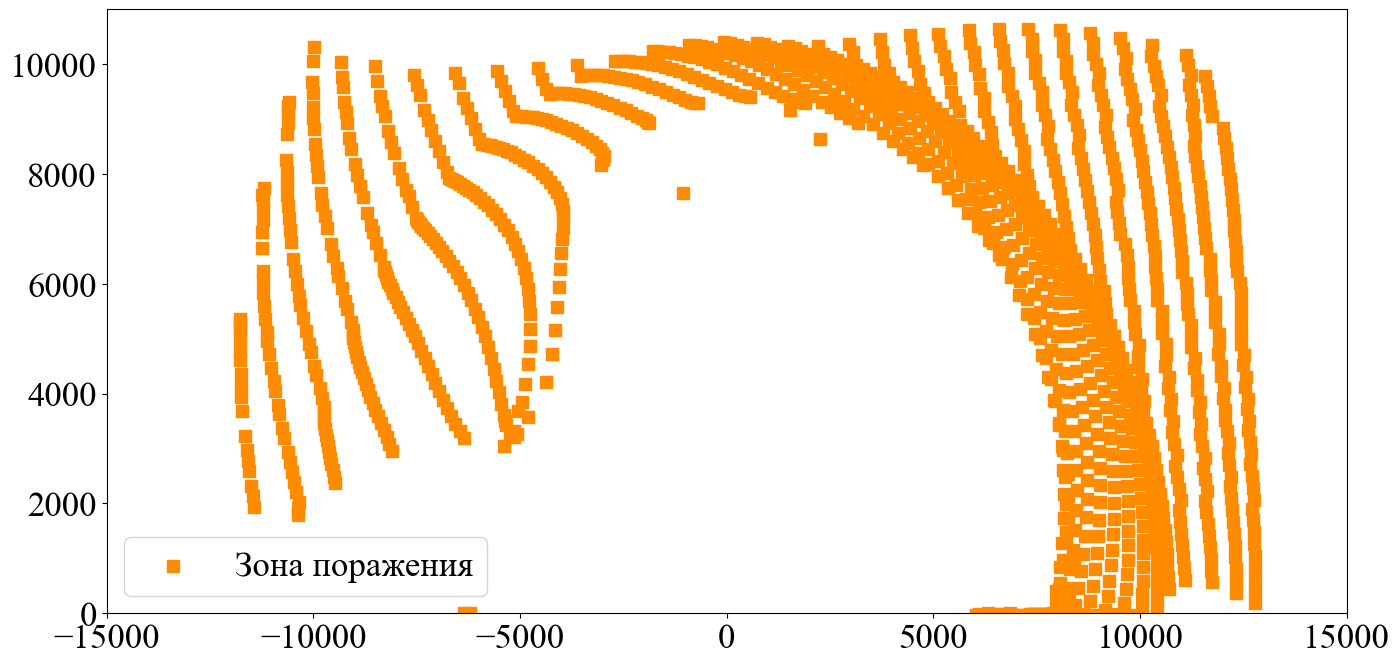

In [82]:
plt.figure(figsize=(16, 8), dpi=100)
plt.scatter(zone_xs, zone_ys, marker='s', color='darkorange', s=70, label='Зона поражения')
# plt.fill_between([-300e3,350e3], [0,0], [-5000,-5000], facecolor='white', hatch='\\\\\\\\\\', linewidth=0.5)
plt.legend(fontsize=25)
# plt.axis('equal')
plt.xlim(-15e3, 15e3)
plt.ylim(0, 11e3)
plt.tick_params(labelsize=25)
# plt.savefig('pictures/Зона поражения.png', dpi=1200, bbox_inches='tight')
plt.show()